<a href="https://colab.research.google.com/github/GDS-Education-Community-of-Practice/DSECOP/blob/connor_module/Time_Series_Analysis_and_Forecasting/N3_Forecasting_Time_Series_with_Recurrent_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Use CPU rather than GPU for keras neural networks
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""
from tensorflow import keras
from tqdm.keras import TqdmCallback

# Notebook 3: Forecasting projectile motion with recurrent neural networks

In notebook 1, we simulated the motion of several trapezoid shaped projectiles that collect information after having been catapulted from the ground. This is an imagined scenario but takes the simple Newtonian motion of an idealized projectile and considers a more realistic scenario which includes varied drag.

This data includes a varied drag coefficient and projectile area for four sides of the object.
A large number of these runs were simulated and saved in the file `launches.csv`.

Notebook 2 demonstrated some classical time series analysis techniques to better understand that data and then demonstrated linear techniques for "forecasting" or predicting the future state of the projectile, given some initial portion of the data.

In this notebook, we will explore the use of neural networks, which are nonlinear models, to forecast future states of the projectile, given the previous locations and other information.
i.e. if we know how the projectile travelled from time $t=0$ to time $t=10$, where will it be at time $t=11$?
Although you can calculate this with Newton's second law, the previous notebook demonstrated that this calculation can be more tricky if you do not know the exact drag coefficient on the projectile.

We begin by loading the file of simulated launches, which will be our data for tuning and testing the neural network parameters.

In [2]:
# Load our launch data
data_location = "https://raw.githubusercontent.com/GDS-Education-Community-of-Practice/DSECOP/connor_module/Time_Series_Analysis_and_Forecasting/launches.csv"
all_launches = pd.read_csv(data_location, index_col="Time (s)")

# Split into individual launches
split_indices = np.where(all_launches.index[1:] - all_launches.index[0:-1] < 0)[0].tolist() # Find where time decreases (signifies different launch)
split_indices = [0] + split_indices + [all_launches.shape[0]]
launches = [all_launches.iloc[split_indices[i]+1:split_indices[i+1]] for i in range(100)]

## Feedforward neural network

*The material in this section is taken heavily from previous DSECOP modules on [introduction to deep learning](https://github.com/GDS-Education-Community-of-Practice/DSECOP/blob/main/Intro_to_Deep_Learning/01_Introduction_to_Neural_Network.ipynb) and [learning differential equations with neural networks](https://github.com/GDS-Education-Community-of-Practice/DSECOP/blob/main/Solving_Differential_Equations_with_NNs/02_neural_networks.ipynb).
Please see those modules for more information on basic neural network architectures.*

An feedforward neural network is a function that was designed to mimic biological neural networks.
It can be written as simply
$$
y = f(W_lf(W_{l-1}(\cdot \cdot \cdot f(W_1\textbf{x} + \textbf{b}_1) \cdot \cdot \cdot) + \textbf{b}_{l-1}) + \textbf{b}_l).
$$
This may look confusing at first glance, but basically it is just a function that takes in a vector (or value) $\textbf{x}$ and outputs a value $y$.
This function is a nested function (in that it repeatedly applies the function $f$) and can be written more legibly as:
$$
y_1 = f(W_1\textbf{x} + \textbf{b}_1) \\
y_2 = f(W_2y_1 + \textbf{b}_2) \\
\vdots \\
y = f(W_ly_{l-1} + \textbf{b}_l)
$$
Note that at the $i^\text{th}$ level, $y_{i-1}$ is the input to the function.




### Structure
You may be wondering how this is similar to biological neural networks.
This is clearer if we write the above in a diagram form:

![](https://raw.githubusercontent.com/GDS-Education-Community-of-Practice/DSECOP/connor_module/Time_Series_Analysis_and_Forecasting/diagrams/feedforward_nn1.drawio.svg)

For some terminology,
- $f$ is an "activation" function (something like $\tanh$)
- $W_i$ is called a "weight" matrix
- $b_i$ is called a "bias" vector
Because $W_i$ are matrices, they can change the dimension at each level.
For example, if our input $\textbf{x}$ was a vector of 3 items, and the matrix $W_1$ was a $5 \times 3$ matrix, then $W_1\textbf{x}$ would be a size 5 vector.
With this in mind, the above diagram is more commonly drawn as:

![](https://raw.githubusercontent.com/GDS-Education-Community-of-Practice/DSECOP/connor_module/Time_Series_Analysis_and_Forecasting/diagrams/feedforward_nn2.drawio.svg)

This diagram shows how the function we wrote above is actually a network.
Each line on the diagram represents an operation like $W_{i,jk}y_{i,k} + b_j$ where $W_{i,jk}$ is the $j,k$ entry in the $W_i$ matrix.
Each circle is the application of the activation function $f$ (which could actually be different at each layer) and are usually called "nodes."
The network is called "feedforward" because data only flows from left to right (there are no loops).

Let's create a simple network with the following properties in the `keras` Python framework:
- $\textbf{x}$ is a vector of length 2
- $W_1,W_2$ are sizes $3\times 2$ and $1 \times 3$ respectively
- $b_1, b_2$ are vectors of size $3$ and $1$ respectively
- $f$ is a $\tanh$ function

In [3]:
# Set the random seed to make sure we get reproducible results (we get the same every time we run)
keras.utils.set_random_seed(0)

# Make input layer of appropriate size (1 sample of size 2)
x   = keras.layers.Input(shape=(2,),name="Input")

# Pass input x into first layer of size 3 x 2
y_1 = keras.layers.Dense(3,activation="tanh")(x)

# Pass middle or "hidden" layer into output
y   = keras.layers.Dense(1,activation="tanh")(y_1)

model = keras.Model(inputs=x,outputs=y)

We can now try putting a vector of size 2 into the network to see the output.

In [4]:
# 1 random sample of size 2
sample = np.random.random(size=(1,2))

print("Sample: {}".format(sample))
print("Result: {}".format(model(sample)))

Sample: [[0.5488135  0.71518937]]
Result: [[0.50497514]]


If we wanted to put in many samples of size 2 and see all of their outputs at the same time, we could write:

In [5]:
# 5 random samples of size 2
samples = np.random.random(size=(5,2))

print("Samples: \n{}".format(samples))
print("Results: \n{}".format(model(samples)))

Samples: 
[[0.60276338 0.54488318]
 [0.4236548  0.64589411]
 [0.43758721 0.891773  ]
 [0.96366276 0.38344152]
 [0.79172504 0.52889492]]
Results: 
[[0.38953546]
 [0.47595912]
 [0.60580003]
 [0.23124357]
 [0.3555    ]]


### Tuning the network

To reiterate, the neural network is just a function.
You input $\textbf{x}$ and it outputs $y$.
For time series forecasting, we'd like to input a sequence of previous time series data $\textbf{x}$ and get out the next point in the series $y$.

In order to make our neural network model function accurate (to get the answer $y$ correct), we can adjust the weights $W_1,W_2,\ldots,W_l$ and biases $b_1,b_2,\ldots,b_l$.
We can do this by considering a "loss" function $\mathcal{L}(y,\hat{y})$ where $\hat{y}$ is the actual value and $y$ is the value predicted by the neural network.
A common loss is just the squared difference:
$$
\mathcal{L}(y,\hat{y}) = (y - \hat{y})^2
$$

Knowing that we want $y$ and $\hat{y}$ to be as close as possible to each other so that our network is accurate, we want to minimize $\mathcal{L}(y,\hat{y})$.
From calculus, we know we can take a derivative of $\mathcal{L}$ and set it to 0.
For a single parameter, this can be written as:
$$
\frac{d}{dW_i}\mathcal{L}(y,\hat{y}) = 0
$$

A significant amount of effort and programming has been put in to be able to automatically calculate these derivatives.
It is thus namely called "automatic differentiation."
Most neural network frameworks obscure these details and let you focus on just the network design (how many nodes, layers $l$, etc.).

Once we can calculate these derivatives, we can use a procedure called "gradient descent" to iteratively adjust the weights and biases to better match our data.
This process is usually called "training" the network.

The `keras` framework makes it easy to select a gradient descent type and loss function and fit to data.
Consider the following example where we have data samples of $x = [\sin(t),\cos(t)]$ for values of $t$ between $0$ and $10$ and we want to output the value $\sin(t)\cos(t)$.
We use the mean squared error loss and the gradient descenet algorithm `adam`.



0epoch [00:00, ?epoch/s]

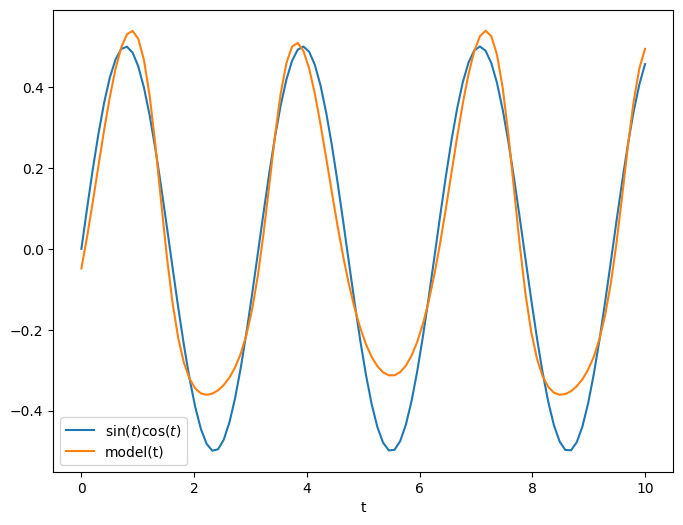

In [6]:
# Make our data samples
t_values = np.linspace(0,10,100)
samples = np.vstack([np.sin(t_values), np.cos(t_values)]).T
output_values = np.sin(t_values)*np.cos(t_values)

# Train model
model.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.MeanSquaredError()
)
history = model.fit(
    samples,
    output_values,
    batch_size=10,         # The training takes groups of samples (in this case 10 samples at a time)
    epochs=500,            # The number of times to iterate through our dataset
    validation_split = 0.2,# Use 20% of data to check accuracy
    verbose=0,             # Don't print info as it trains
    callbacks=[TqdmCallback(verbose=0)]
)

# Plot prediction and the true values
plt.close('all')
plt.figure(figsize=(8,6))
plt.plot(t_values, output_values, label="$\sin(t)\cos(t)$")
plt.plot(t_values, model(samples), label="model(t)")
plt.legend()
plt.xlabel("t")
plt.show()

Not bad!
Using automatic differentiation and gradient descent, the neural network weights and biases have been adjusted to make the neural network approximate the function $\sin(t)\cos(t)$.
It is not perfect, but it gets the general shape.
We could increase the number of `epochs` to train for longer and improve the accuracy.

## Recurrent neural network

A "recurrent" neural network is not exactly feedforward.
There are a variety of forms for a recurrent network, but using the previous diagramming method, we can write the most common form as:

![](https://raw.githubusercontent.com/GDS-Education-Community-of-Practice/DSECOP/connor_module/Time_Series_Analysis_and_Forecasting/diagrams/recurrent_nn_loop.drawio.svg)

As you can see, there is a loop (the recurrent part) which passes information from one evaluation of the function to the next time the function is evaluated.
This might seem strange at first glance but makes more sense when you consider a sequence of events.
For example, words.
If we have three words of a sentence, predicting the next word likely depends on all three words rather than only the previous.



### Structure
The "looped" diagram shown above can also be written in an "unrolled" form as follows:

**Many-to-many**

![](https://raw.githubusercontent.com/GDS-Education-Community-of-Practice/DSECOP/connor_module/Time_Series_Analysis_and_Forecasting/diagrams/recurrent_nn1.drawio.svg)

Note that this form of recurrent neural network requires inputs at each step and gives outputs at each step.
This is is not strictly necessary and you could instead have only the end output or only one input and one output as show below:

**Many-to-one**
![](https://raw.githubusercontent.com/GDS-Education-Community-of-Practice/DSECOP/connor_module/Time_Series_Analysis_and_Forecasting/diagrams/recurrent_nn2.drawio.svg)

**One-to-one**
![](https://raw.githubusercontent.com/GDS-Education-Community-of-Practice/DSECOP/connor_module/Time_Series_Analysis_and_Forecasting/diagrams/recurrent_nn3.drawio.svg)


Each of the demonstrated diagrams features a very simple version of the neural network, but it could have many layers at each step such as the following:

![](https://raw.githubusercontent.com/GDS-Education-Community-of-Practice/DSECOP/connor_module/Time_Series_Analysis_and_Forecasting/diagrams/recurrent_nn_loop2.drawio.svg)


Fortunately, these can all be easily implemented using the `keras` framework.
Let's return to our example of input data of the form $[\sin(t),\cos(t)]$ and outputs of the form $\sin(t)\cos(t)$ but lets try to use 2 values of $t$ to get the next value.
So, we will pass in something like
$$
\begin{bmatrix}
\sin(t_1) & \cos(t_1) \\
\sin(t_2) & \cos(t_2)
\end{bmatrix}
$$
to get the output $\sin(t_3)\cos(t_3)$.
We'll use two layers.
See below for examples of these recurrent neural network forms:

In [7]:
keras.utils.set_random_seed(0)

# Make input layer of appropriate size (2 samples of size 2 or 1 sample of size 2)
x_many   = keras.layers.Input(shape=(2,2))
x_one    = keras.layers.Input(shape=(1,2))

# Pass input x into first layer of size 3 x 2
# return_sequences=True means there is an output for each input
y_many = keras.layers.SimpleRNN(3,activation="tanh", return_sequences=True)(x_many)
y_one  = keras.layers.SimpleRNN(3,activation="tanh", return_sequences=True)(x_one)
y_many_to_many = keras.layers.SimpleRNN(1,activation="tanh", return_sequences=True)(y_many)
y_many_to_one  = keras.layers.SimpleRNN(1,activation="tanh", return_sequences=False)(y_many)
y_one_to_one   = keras.layers.SimpleRNN(1,activation="tanh", return_sequences=False)(y_one)

many_to_many = keras.Model(inputs=x_many,outputs=y_many_to_many)
many_to_one  = keras.Model(inputs=x_many,outputs=y_many_to_one)
one_to_one   = keras.Model(inputs=x_one ,outputs=y_one_to_one)

In [8]:
# 1 batch of 2 random samples of size 2
sample_many = np.random.random(size=(1,2,2))
sample_one  = np.random.random(size=(1,1,2))

print("Sample of 2: \n{}".format(sample_many))
print("Many to many output: \n{}".format(many_to_many(sample_many)))
print("Many to one output: \n{}".format(many_to_one(sample_many)))
print("Sample of 1: \n{}".format(sample_one))
print("One to one output: \n{}".format(one_to_one(sample_one)))

Sample of 2: 
[[[0.5488135  0.71518937]
  [0.60276338 0.54488318]]]
Many to many output: 
[[[0.2860116]
  [0.5201849]]]
Many to one output: 
[[-0.04503517]]
Sample of 1: 
[[[0.4236548  0.64589411]]]
One to one output: 
[[0.37018642]]


The number passed into the `SimpleRNN` is the number of loops performed.
In the case described above, we want to take samples at times $t_1$ and $t_2$ and output the value of the function at time $t_3$.
This is a "many-to-one" case.

In order to train the network to perform well in this case, we need to arrange our data in pairs of
$$
\begin{bmatrix}
\sin(t_i) & \cos(t_{i}) \\
\sin(t_{i+1}) & \cos(t_{i+1})
\end{bmatrix}
$$ aligned with outputs $\sin(t_{i+2})\cos(t_{i+2})$:

In [9]:
# Arrange our data samples
input_samples = []
output_samples = []
for i in range(98):
  # Take two samples at time t_i and t_{i+1}
  input_samples.append(samples[i:i+2])
  # Get function output at time t_{i+2}
  output_samples.append(output_values[i+2])

input_samples = np.array(input_samples)
output_samples = np.array(output_samples)

We can now compile the many to one model and train it on this test data.

0epoch [00:00, ?epoch/s]

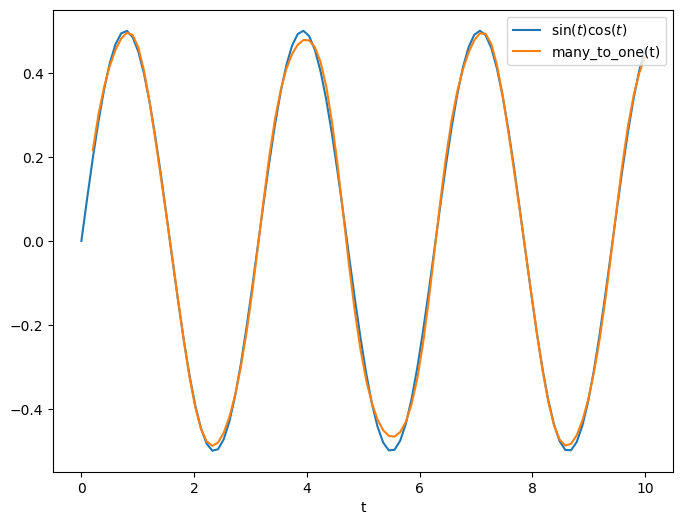

In [10]:
# Train model
many_to_one.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.MeanSquaredError()
)
history = many_to_one.fit(
    input_samples,
    output_samples,
    batch_size=10,         # The training takes groups of samples (in this case 10 samples at a time)
    epochs=500,            # The number of times to iterate through our dataset
    validation_split = 0.2,# Use 20% of data to check accuracy
    verbose=0,             # Don't print info as it trains
    callbacks=[TqdmCallback(verbose=0)]
)

# Plot prediction and the true values
plt.close('all')
plt.figure(figsize=(8,6))
plt.plot(t_values, output_values, label="$\sin(t)\cos(t)$")
plt.plot(t_values[2:], many_to_one(input_samples), label="many_to_one(t)")
plt.legend()
plt.xlabel("t")
plt.show()

Similar to the feedforward neural network, the recurrent architecture was able to roughly approximate the curve!
Although it is not very noticeable in this case, the recurrent model can also uses less weights and biases (because it has the looping behavior built in) making it less computationally expensive and easier to train!
This has made the recurrent architecture very popular for time series like applications for real world problems (in fact, modern transformers such as ChatGPT are built on the same concepts as RNNs).

## Forecasting projectile data with recurrent neural networks

Recurrent neural networks are mainly used for sequential information because of their repetitive nature.
This is perfectly suited for time series data such as our projectile data.

Similarly to the application of the ARMA linear model in notebook 2, we will consider our test launch as our training data.
As we did in the example, we will consider taking two steps of the distance variable and try to predict the next distance.

In [11]:
# Get our test launch data
test_launch = launches[20]

# Take the first quarter of the data
distance = test_launch["Distance (m)"]
quarter_distance = np.array(distance.iloc[1:17])
quarter_height = np.array(test_launch["Height (m)"].iloc[1:17])

# Organize the data for our recurrent neural network
k = 2
distance_in = []
distance_out = []
for i in range(len(quarter_distance)-k):
  # Take k samples at time t_i ... t_{i+k-1}
  distance_in.append(quarter_distance[i:i+k].reshape((k,1)))
  # Get function output at time t_{i+k}
  distance_out.append(quarter_distance[i+k])

distance_in = np.array(distance_in)
distance_out = np.array(distance_out)

In [12]:
keras.utils.set_random_seed(0)

# Make simple many to one model (input 2 samples of size 1)
x = keras.layers.Input(shape=(k,1))
y = keras.layers.SimpleRNN(10,activation="tanh", return_sequences=True)(x)
y = keras.layers.SimpleRNN(1,activation="linear", return_sequences=False)(y)
distance_model  = keras.Model(inputs=x,outputs=y)

# Train model
distance_model.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.MeanSquaredError()
)
history = distance_model.fit(
    distance_in,
    distance_out,
    batch_size=10,         # The training takes groups of samples (in this case 10 samples at a time)
    epochs=2000,           # The number of times to iterate through our dataset
    validation_split = 0 , # Use 0% of data to check accuracy
    verbose=0,             # Don't print info as it trains
    callbacks=[TqdmCallback(verbose=0)]
)

0epoch [00:00, ?epoch/s]

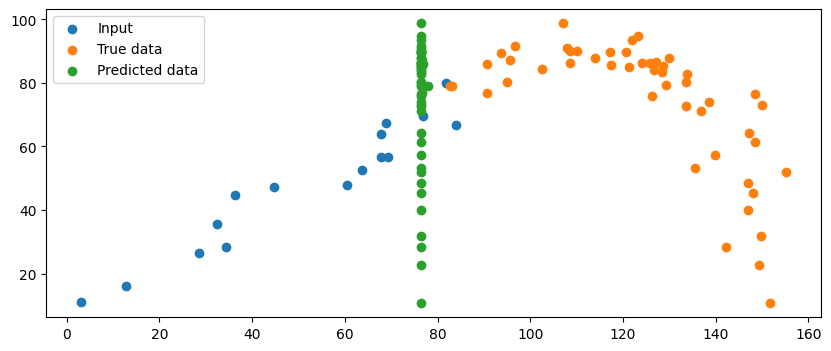

In [13]:
# Plot prediction and the true values
data_distance = distance.iloc[17:]
data_height = test_launch["Height (m)"].iloc[17:]

# Run predictions through the model to get the next time step
predictions = [distance_in[-1][i,0] for i in range(k)]
for i in range(len(data_distance)):
  # Get the k previous steps
  i_input = np.array([predictions[-i] for i in range(k,0,-1)])
  prediction = distance_model(i_input.reshape((1,k,1)))
  # Convert single value matrix to just a number
  predictions.append(np.array(prediction)[0][0])

# Cut out first k predictions (that we actually already knew)
predictions = np.array(predictions[k:])

# Plot
plt.close('all')
plt.figure(figsize=(10,4))
plt.scatter(quarter_distance, quarter_height, label="Input")
plt.scatter(data_distance, data_height, label="True data")
plt.scatter(predictions, data_height, label="Predicted data")
plt.legend()
plt.show()

Well, those predictions are no good!
Apparently, our model is unable to predict the next portion of the data..
This is because the model is not good at "extrapolation" or predicting beyond where it was trained (this is more common for nonlinear models than for linear models like ARMA because they are more flexible).
Note that all of the input data is in the range 0 to 75.
It seems that as soon as we give data beyond that, the model spits out values that it has seen before.

One way to avoid this issue would be to first make our data stationary or close to stationary (see notebook 2 for more information).
We can do this by subtracting the data at the previous time from the current data.
Our new stationary distance will then be in the range of the training data and work better with our network.

0epoch [00:00, ?epoch/s]

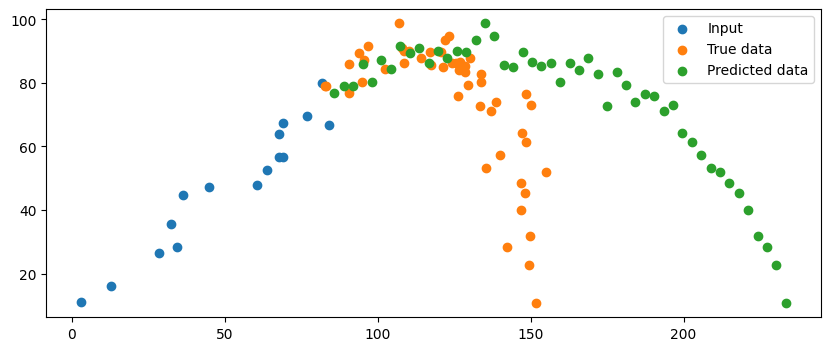

In [14]:
keras.utils.set_random_seed(0)

# Take the first quarter of the data (stationary)
original_distance = test_launch["Distance (m)"].shift()
distance = test_launch["Distance (m)"] - test_launch["Distance (m)"].shift()
quarter_distance = np.array(distance.iloc[1:17])
quarter_height = np.array(test_launch["Height (m)"].iloc[1:17])

# Organize the data for our recurrent neural network
k = 2
distance_in = []
distance_out = []
for i in range(len(quarter_distance)-k):
  # Take k samples at time t_i ... t_{i+k-1}
  distance_in.append(quarter_distance[i:i+k].reshape((k,1)))
  # Get function output at time t_{i+k}
  distance_out.append(quarter_distance[i+k])

distance_in = np.array(distance_in)
distance_out = np.array(distance_out)

# Make simple many to one model (input 2 samples of size 1)
x = keras.layers.Input(shape=(k,1))
y = keras.layers.SimpleRNN(10,activation="tanh", return_sequences=True)(x)
y = keras.layers.SimpleRNN(1,activation="linear", return_sequences=False)(y)
distance_model  = keras.Model(inputs=x,outputs=y)

# Train model
distance_model.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.MeanSquaredError()
)
history = distance_model.fit(
    distance_in,
    distance_out,
    batch_size=10,         # The training takes groups of samples (in this case 10 samples at a time)
    epochs=2000,           # The number of times to iterate through our dataset
    validation_split = 0,  # Use 0% of data to check accuracy
    verbose=0,             # Don't print info as it trains
    callbacks=[TqdmCallback(verbose=0)]
)

# Plot prediction and the true values
data_distance = distance.iloc[17:]
data_height = test_launch["Height (m)"].iloc[17:]

# Run predictions through the model to get the next time step
predictions = [distance_in[-1][i,0] for i in range(k)]
for i in range(len(data_distance)):
  # Get the k previous steps
  i_input = np.array([predictions[-i] for i in range(k,0,-1)])
  prediction = distance_model(i_input.reshape((1,k,1)))
  # Convert single value matrix to just a number
  predictions.append(np.array(prediction)[0][0])

# Cut out first k predictions (that we actually already knew)
predictions = np.array(predictions[k:])

# Shift data and predictions
shift_quarter_distance = quarter_distance+original_distance.iloc[1:17]
shift_data_distance = data_distance+original_distance.iloc[17:]
shift_predictions = [predictions[0]+original_distance.iloc[17]]
for pred in predictions[1:]:
  shift_predictions.append(pred + shift_predictions[-1])

# Plot
plt.close('all')
plt.figure(figsize=(10,4))
plt.scatter(shift_quarter_distance, quarter_height, label="Input")
plt.scatter(shift_data_distance, data_height, label="True data")
plt.scatter(shift_predictions, data_height, label="Predicted data")
plt.legend()
plt.show()

Well that worked enormously better!
But the results still look somewhat equivalent to the linear models of ARMA in notebook 2.

----
### Problem 1

Try adding more `SimpleRNN` layers, changing the number of nodes in the layers, adding more training `epochs`, and adjusting the number of time points `k` for the dataset to acheive more accurate results.

How close can you get?

*Note:* It is recommended that you change one at a time to see how each component affects the results.

In [15]:
# Answer for Problem 1

----

Now, up until now, our data has been entirely based on the distance information.
However, our dataset contains more than just distance.
Also, notably, classical linear models such as ARMA cannot easily incorporate more than one variable.
But neural networks are very well suited to high dimensional data.

What if we also include the height variable in the training and prediction?

0epoch [00:00, ?epoch/s]

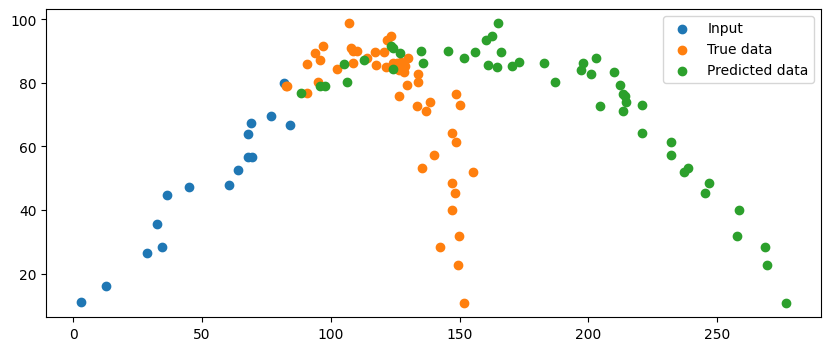

In [16]:
keras.utils.set_random_seed(0)

# Take the first quarter of the data (stationary)
original_dh = test_launch[["Distance (m)", "Height (m)"]].shift()
dh_data = test_launch[["Distance (m)", "Height (m)"]] - test_launch[["Distance (m)", "Height (m)"]].shift()
quarter_dh = np.array(dh_data.iloc[1:17])
quarter_height = np.array(test_launch["Height (m)"].iloc[1:17])

# Organize the data for our recurrent neural network
k = 4
dh_in = []
distance_out = []
for i in range(len(quarter_dh)-k):
  # Take k samples at time t_i ... t_{i+k-1}
  dh_in.append(quarter_dh[i:i+k])
  # Get function output at time t_{i+k}
  distance_out.append(quarter_dh[i+k,0])

dh_in = np.array(dh_in)
distance_out = np.array(distance_out)

# Make simple many to one model (input 2 samples of size 2 variables)
x = keras.layers.Input(shape=(k,2))
y = keras.layers.SimpleRNN(10,activation="tanh", return_sequences=True)(x)
y = keras.layers.SimpleRNN(1,activation="linear", return_sequences=False)(y)
dh_model  = keras.Model(inputs=x,outputs=y)

# Train model
dh_model.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.MeanSquaredError()
)
history = dh_model.fit(
    dh_in,
    distance_out,
    batch_size=10,         # The training takes groups of samples (in this case 10 samples at a time)
    epochs=2000,           # The number of times to iterate through our dataset
    validation_split = 0,  # Use 0% of data to check accuracy
    verbose=0,             # Don't print info as it trains
    callbacks=[TqdmCallback(verbose=0)]
)

# Plot prediction and the true values
data_distance = test_launch["Distance (m)"].iloc[17:]
data_height = test_launch["Height (m)"].iloc[17:]

# Run predictions through the model to get the next time step
predictions = [dh_in[-1][i,0] for i in range(k)]
for i in range(len(data_distance)):
  # Get the k previous steps of height and with predicted distance
  i_input = np.vstack([
      np.array([predictions[-i] for i in range(k,0,-1)]),
      np.array([dh_data["Height (m)"].iloc[17+i-j] for j in range(k,0,-1)])
  ]).T
  prediction = dh_model(i_input.reshape((1,k,2)))
  # Convert single value matrix to just a number
  predictions.append(np.array(prediction)[0][0])

# Cut out first k predictions (that we actually already knew)
predictions = np.array(predictions[k:])

# Shift data and predictions
shift_quarter_distance = quarter_dh[:,0]+original_dh["Distance (m)"].iloc[1:17]
shift_data_distance = data_distance
shift_predictions = [predictions[0]+original_dh["Distance (m)"].iloc[17]]
for pred in predictions[1:]:
  shift_predictions.append(pred + shift_predictions[-1])

# Plot
plt.close('all')
plt.figure(figsize=(10,4))
plt.scatter(shift_quarter_distance, quarter_height, label="Input")
plt.scatter(shift_data_distance, data_height, label="True data")
plt.scatter(shift_predictions, data_height, label="Predicted data")
plt.legend()
plt.show()

This result doesn't look too different from our previous result, but notice that we needed to change to use `k=4` previous time points to make the prediction.
You can try to use `k=2` to see the interesting predictions that it yields (because the height values repeat themselves when the projectile comes back down, the distance prediction go backward!).

----

### Problem 2

Using the example above, include the other variables in our dataset.
Namely, include the drag coefficient and projectile area.

Do these help with the prediction accuracy (without changing anything else)?
Why or why not might that be?

In [17]:
# Answer to problem 2


----


### Problem 3

So far, we have only used a single test launch.
However, the network training can be improved by incorporating all of the launches.
In fact, all of the launches can be used in their entirety to train the network, after which we can test it on the case we have been considering.

In this problem, fit (or train) the network on all of the data contained in `launches` except for the 20th entry (which is `test_launch`), then predict on the last 3/4 of the data from `test_launch` as the previous examples and problems have shown.

*Note:* You will likely need to decrease the number of `epochs` due to the much larger dataset.
Also, use `np.any(np.isnan())` to make sure you don't add anything with `NaN` (not a number) to the dataset.

In [18]:
# Answer to problem 3

----

## Appendix

**Resources:**
- https://towardsdatascience.com/time-series-forecasting-deep-learning-vs-statistics-who-wins-c568389d02df